**CSCI 4831: Sabermetrics Final Project**  
Name: Adam Ten Hoeve

https://github.com/aaronaaeng/Sabermetrics-Final-Project

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# Read in all of the statcast data
# df2016 = pd.read_csv("2016/data2016.csv")

# april2017 = pd.read_csv("2017/dataApril2017.csv")
# may2017 = pd.read_csv("2017/dataMay2017.csv")
# june2017 = pd.read_csv("2017/dataJune2017.csv")
# july2017 = pd.read_csv("2017/dataJuly2017.csv")
# aug2017 = pd.read_csv("2017/dataAug2017.csv")
# sept2017 = pd.read_csv("2017/dataSept2017.csv")
# oct2017 = pd.read_csv("2017/dataOct2017.csv")

april2018 = pd.read_csv("2018/dataApril2018.csv")
# may2018 = pd.read_csv("2018/dataMay2018.csv")
# june2018 = pd.read_csv("2018/dataJune2018.csv")
# july2018 = pd.read_csv("2018/dataJuly2018.csv")
# aug2018 = pd.read_csv("2018/dataAug2018.csv")
# sept2018 = pd.read_csv("2018/dataSept2018.csv")
# oct2018 = pd.read_csv("2018/dataOct2018.csv")

# df2017 = pd.concat([april2017, may2017, june2017, july2017, aug2017, sept2017, oct2017])
# df2018 = pd.concat([april2018, may2018, june2018, july2018, aug2018, sept2018, oct2018])

# dfTotal = pd.concat([df2016, df2017, df2018])
dfTotal = april2018.copy()

In [57]:
# Clean the data. 
# Group by pitcher. Get rid of anyone who pitched less than 100 times in the three years.
dfTempPitch = dfTotal.groupby("player_name", as_index = False).count()
dfTempPitch = dfTempPitch.loc[dfTempPitch["index"] > 100]
# Then group by batter to get rid of any batters who batted less than 100 times.
dfTempBat = dfTotal.groupby("batter", as_index = False).count()
dfTempBat = dfTempBat.loc[dfTempBat["index"] > 100]

# Create a database of pitchers 
dfPitchers = pd.merge(dfTotal, dfTempPitch[["player_name"]], on = "player_name", how = "inner")
# Create a database of batters
dfBatters = pd.merge(dfTotal, dfTempBat[["batter"]], on = "batter", how = "inner")

# Create a final dataframe of the cleaned batter and pitcher data
dfFinal = pd.merge(dfPitchers, dfBatters[["index", "pitcher", "batter", "release_speed", "strikes", "balls"]], on = ["index", "pitcher", "batter", "release_speed", "strikes", "balls"], how = "inner")

In [58]:
# A list of events of the batter either striking out or hitting the ball into play.
events = ["strikeout", "strikeout_double_play", "single", "double", "triple", "home_run", "sac_bunt", "sac_fly", "field_out", "field_error", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play", "walk", "hit_by_pitch"]
# Get rid of all the rows of data that don't have one of the events listed.
Outcomes = dfFinal.loc[dfFinal["events"].isin(events)]

In [59]:
# Calculate the proportion of each type of event. Will be used to calculate the weight of certain outcomes.
OutcomesProp = Outcomes.groupby("events", as_index = False).count()
numEvents = len(Outcomes)
OutcomesProp["proportion"] = OutcomesProp["index"] / numEvents
OutcomesProp = OutcomesProp[["events", "index", "proportion"]]
OutcomesProp

,events,index,proportion
0,double,1194,0.047000
1,double_play,60,0.002362
2,field_error,228,0.008975
3,field_out,10343,0.407141
4,grounded_into_double_play,478,0.018816
5,hit_by_pitch,305,0.012006
6,home_run,750,0.029523
7,sac_bunt,55,0.002165
8,sac_fly,188,0.007400
9,sac_fly_double_play,3,0.000118


In [64]:
# Create a dictionary of all batters and pitchers
batterElos = {}
pitcherElos = {}

# ids = list(Outcomes["pitcher"].unique()) + list(Outcomes["batter"].unique())
for id in list(Outcomes["pitcher"].unique()):
    pitcherElos[id] = 1000
for id in list(Outcomes["batter"].unique()):
    batterElos[id] = 1000
    
# Create a list of pitcher-favored outcomes.
pitcherFavored = ["strikeout", "strikeout_double_play", "field_out", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play"]
# Create a list of batter favored outcomes, meaning they did not get out by the end of the play.
batterFavored = ["single", "double", "triple", "home_run", "field_error", "walk", "hit_by_pitch", "sac_bunt", "sac_fly"]

In [77]:
# Create a dictionary of actual historical result data. This will be to compare the predicted outcome probabilities
histResults = {}
for pid in list(Outcomes["pitcher"].unique()):
        for bid in list(Outcomes["batter"].unique()):
            histResults[(pid, bid)] = np.array([0,0])

In [39]:
def PercentOnBase(row):
    if row["events"] in batterFavored:
        return 1
    return 0

# Find how often batters get on base
total = len(Outcomes)
probBatterWins = np.sum(Outcomes.apply(PercentOnBase, axis = 1)) / total

In [72]:
# Batters only "win" about 35% of the time. So weight the eventual scores so it's as if they win 50% of the time.
# Way better than the old system of weighting scores individually
batterWeight = 0.5 / probBatterWins
pitcherWeight = 0.5 / (1 - probBatterWins)

print(batterWeight, pitcherWeight)

1.4476863460223386 0.7638003607937462


In [53]:
# Determines the weight on the elo based on the type of event.
# Used to balance the proportion of pitcher-wins to batter-wins.
# Otherwise pitchers win about 70% of the time and dominate the scores
def EloEventWeight(event):
    # If that event occured
    if event == "strikeout":
        # Return the prob of that event times the assigned weight based on impact
        # All weights have are *2 what they normally are to speed up processing by preventing floating point arithmetic.
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout"]["proportion"] * 2
    elif event == "field_out":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_out"]["proportion"] * 1
    elif event == "double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "double_play"]["proportion"] * 4
    elif event == "grounded_into_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "grounded_into_double_play"]["proportion"] * 4
    elif event == "strikeout_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout_double_play"]["proportion"] * 4
    elif event == "triple_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple_play"]["proportion"] * 6
    elif event == "sac_fly_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly_double_play"]["proportion"] * 2
    elif event == "single":
        return OutcomesProp.loc[OutcomesProp["events"] == "single"]["proportion"] * 2
    elif event == "double":
        return OutcomesProp.loc[OutcomesProp["events"] == "double"]["proportion"] * 4
    elif event == "triple":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple"]["proportion"] * 6
    elif event == "home_run":
        return OutcomesProp.loc[OutcomesProp["events"] == "home_run"]["proportion"] * 8
    elif event == "sac_bunt":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_bunt"]["proportion"] * 2
    elif event == "sac_fly":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly"]["proportion"] * 2
    elif event == "field_error":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_error"]["proportion"] * 2
    elif event == "walk":
        return OutcomesProp.loc[OutcomesProp["events"] == "walk"]["proportion"] * 2
    elif event == "hit_by_pitch":
        return OutcomesProp.loc[OutcomesProp["events"] == "hit_by_pitch"]["proportion"] * 2
    else:
        # something got through that wasn't supposed to get through
        print(event)
        return 0.5

In [41]:
# Create a function to calculate the probability a pitcher wins the matchup
def ProbPitcherWins(pitcher, batter):
    # Get ranking of pitcher
    pitcherRank = pitcherElos[pitcher]
    # Get ranking of batter
    batterRank = batterElos[batter]
    # From elo rankings. Assumes a difference of 400 is the same as 1 player being 10 times as likely to win
    probPitcherWins = 1 / (1 + 10**((pitcherRank -  batterRank)/400))
    return probPitcherWins

In [78]:
# Create a function to update the scores of players based on the results of pitches
def UpdateElo(row):
    p = row["pitcher"]
    b = row["batter"]
    # Get the probability that the pitcher wins from the function above
    prob = ProbPitcherWins(p, b)
    # Update the ratings based on the outcome of the pitch
    # If pitcher "wins" the matchup
    if row["events"] in pitcherFavored:
        # Largest possible change in score is 32.
        # Shown 16 here because *2 in weight function to prevent float multiplication.
        pitcherElos[p] = int(pitcherElos[p] + (32 * pitcherWeight * (1 - prob)))
        batterElos[b] = int(batterElos[b] + (32 * pitcherWeight * (prob - 1)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([1, 0])
    # If the batter wins the matchup
    else:
        pitcherElos[p] = int(pitcherElos[p] + (32 * batterWeight * (prob - 1)))
        batterElos[b] = int(batterElos[b] + (32 * batterWeight * (1 - prob)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([0, 1])

In [80]:
Outcomes.apply(UpdateElo, axis = 1);

In [81]:
print(max(list(batterElos.values())))

1315


In [82]:
print(list(batterElos.values()))

[961, 1003, 1032, 672, 1296, 805, 894, 840, 1051, 900, 1067, 916, 996, 786, 998, 1161, 1274, 1311, 1024, 1025, 904, 926, 659, 826, 1177, 497, 1021, 788, 956, 655, 907, 1066, 1124, 1022, 652, 1016, 887, 879, 859, 938, 1135, 1061, 1143, 1057, 1096, 694, 934, 1019, 1204, 798, 1144, 1036, 912, 848, 1035, 1094, 501, 921, 994, 1071, 1013, 1135, 1203, 924, 870, 972, 864, 737, 534, 1035, 730, 1000, 1194, 1108, 433, 933, 964, 785, 1074, 1175, 993, 952, 969, 859, 1148, 1292, 486, 1225, 990, 906, 1081, 965, 1068, 1191, 1108, 1029, 907, 828, 985, 782, 615, 933, 1047, 651, 1014, 575, 874, 1315, 991, 1005, 964, 950, 612, 1081, 1006, 1252, 1047, 1026, 921, 993, 1053, 916, 1126, 701, 856, 1159, 935, 1036, 1139, 954, 678, 660, 997, 968, 1017, 1007, 871, 1166, 716, 886, 679, 827, 1092, 1061, 1012, 858, 1053, 759, 724, 868, 914, 809, 1036, 982, 777, 1156, 157, 585, 1053, 1016, 1011, 965, 996, 1022, 783, 862, 1015, 942, 1178, 994, 1047, 725, 736, 801, 1079, 1129, 1039, 935, 1016, 780, 934, 997, 792, 775, 

In [83]:
print(max(list(pitcherElos.values())))

2054


In [84]:
print(list(pitcherElos.values()))

[932, 949, 1161, 937, 1014, 1028, 852, 693, 1026, 853, 911, 1214, 900, 774, 1124, 788, 1125, 876, 805, 925, 988, 1057, 914, 980, 1146, 1137, 897, 941, 1123, 805, 876, 1029, 1011, 915, 1041, 1003, 996, 936, 1001, 909, 1069, 978, 1069, 908, 1283, 1028, 1091, 1095, 1343, 962, 713, 1546, 1108, 972, 1005, 940, 955, 987, 1022, 779, 714, 1009, 1100, 1190, 975, 920, 1241, 1013, 1009, 966, 1024, 979, 949, 933, 850, 904, 988, 1334, 968, 910, 1349, 752, 1009, 825, 1184, 637, 1100, 825, 1773, 808, 867, 1032, 1031, 817, 1050, 820, 807, 1229, 919, 1100, 939, 1027, 899, 880, 772, 951, 1184, 1003, 1156, 948, 1814, 1092, 1050, 1031, 1164, 1197, 1004, 791, 888, 907, 1117, 910, 1123, 931, 580, 1149, 925, 1324, 996, 872, 800, 1179, 1031, 1049, 1006, 748, 822, 990, 1099, 854, 946, 963, 1030, 881, 790, 1048, 1242, 968, 1045, 873, 805, 1423, 776, 948, 891, 952, 856, 866, 771, 1013, 885, 1216, 1069, 952, 832, 862, 952, 1329, 962, 1113, 806, 1047, 893, 991, 1006, 1276, 943, 739, 977, 949, 1029, 912, 715, 1037,

In [14]:
# Create dictionaries to convert player names and ids
IDtoName = {}
NametoID = {}
# Get all the unique players
temp = Outcomes[["player_name", "pitcher"]].groupby(by = "pitcher", as_index = False).first()

for i in range(len(temp)):
    IDtoName[temp["pitcher"].iloc[i]] = temp["player_name"].iloc[i]
    NametoID[temp["player_name"].iloc[i]] = temp["pitcher"].iloc[i]

In [13]:
# Create a dictionary to convert the player ID's to names
def PlayerIDtoName(id):
    return(IDtoName[id])

# Create a function to convert player's name to ID
def PlayerNametoID(name):
    return(NametoID[name])

In [100]:
def PredictWinner(pitcherID, batterID):
    # Get the elos of both players
    probPWins = ProbPitcherWins(pitcherID, batterID)
    print("The probability that the pitcher wins is", probPWins)
    
    # Find the actual historical data on who won the at-bat
    histData = histResults[(pitcherID, batterID)]
    percentPWon = histData[0] / np.sum(histData)
    print("The percentage of at-bat appearances the pitcher won is", percentPWon)

In [101]:
PredictWinner(433587.0, 134181.0)
PredictWinner(592811.0, 134181.0)
PredictWinner(543037.0, 134181.0)

The probability that the pitcher wins is 0.8576633185538569
The percentage of at-bat appearances the pitcher won is 0.6666666666666666
The probability that the pitcher wins is 0.8065275228171078
The percentage of at-bat appearances the pitcher won is 0.6666666666666666
The probability that the pitcher wins is 0.013310080776597268
The percentage of at-bat appearances the pitcher won is 0.8333333333333334


(array([ 19.,  85., 163.,  79.,  28.,   8.,   4.,   1.,   3.,   2.]),
 array([ 580. ,  727.4,  874.8, 1022.2, 1169.6, 1317. , 1464.4, 1611.8,
        1759.2, 1906.6, 2054. ]),
 <a list of 10 Patch objects>)

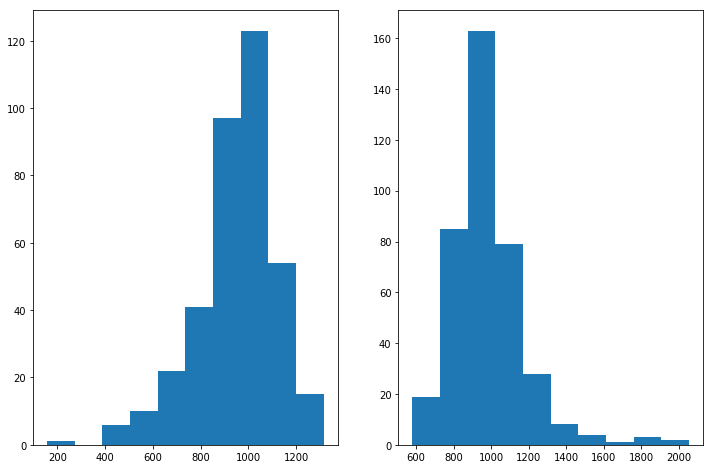

In [107]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].hist(batterElos.values())
ax[1].hist(pitcherElos.values())